## Purpose:
#### 1.Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
#### 2.Explain why that might be happening. Are the localized translations really worse?

Note: The most likely reasons for weird A/B test result is: 
1. We didn’t collect enough data.
2. Some bias has been introduced in the experiment so that test/control people are not really random.

### I. Load Data 

In [50]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
import datetime as dt
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [4]:
test = pd.read_csv('test_table.csv',parse_dates= ['date'])
user = pd.read_csv('user_table.csv')

In [11]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 31.1+ MB


In [13]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [14]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [15]:
## test uniqueness 
print ('Test_data\t', test['user_id'].nunique(), '\t', test['user_id'].nunique() == len(test))
print ('User_data\t', user['user_id'].nunique(), '\t', user['user_id'].nunique() == len(user))


Test_data	 453321 	 True
User_data	 452867 	 True


In [5]:
## join two tables
data = pd.merge(test, user, on = 'user_id', how = 'left')
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 45.0+ MB


In [35]:
data.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


### II. A/B Test 
Since we know the test is negative, first verify result

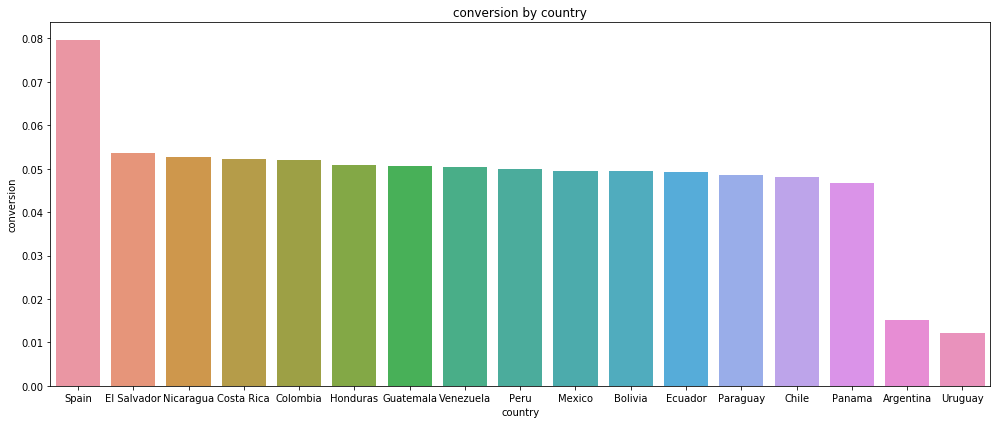

In [6]:
# First check Spain converts much better than other countires 
group_country = data[data['test'] == 0][['country','conversion']].groupby('country').mean().reset_index()
group_country = group_country.sort_values('conversion', ascending= False)

fig, ax = plt.subplots(figsize = (14,6))
sns.barplot(x= 'country', y = 'conversion', data= group_country)
ax.set_title('conversion by country')
plt.tight_layout()

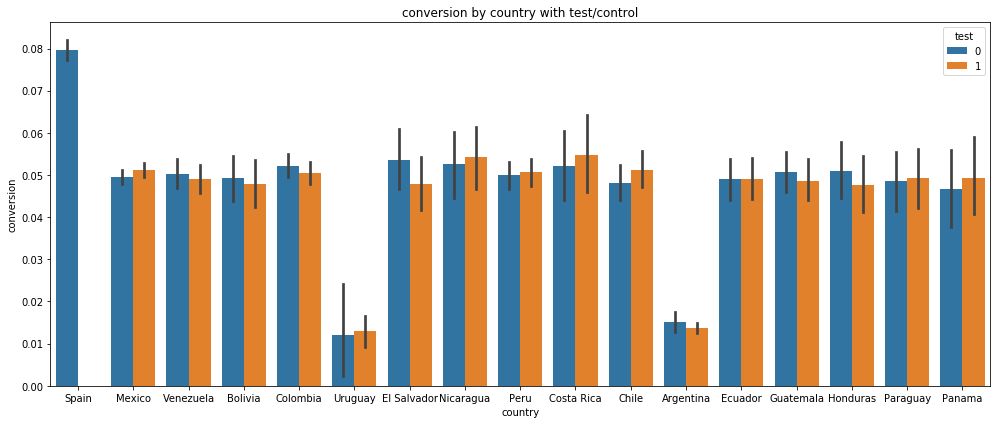

In [7]:
fig, ax = plt.subplots(figsize = (14,6))
sns.barplot(x= 'country', y = 'conversion', hue = 'test', data= data)
ax.set_title('conversion by country with test/control')
plt.tight_layout()
# almost 50/50 split for test/ control 

In [8]:
## A/B test 
test_data = data[data['country'] != 'Spain'] # remove spain since not testing on it
test_val = test_data[test_data['test'] == 1]['conversion'].values
con_val = test_data[test_data['test'] == 0]['conversion'].values

print(test_val.mean(), '\t', con_val.mean())

0.043424713982118966 	 0.04833042316066309


In [9]:
ttest_ind(test_val, con_val, equal_var= False)

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)

#### Finding: 
1. After apply the new method, conversion decreased by 10%, which is weird
2. This is due to some small sample size or bias introduced somewhere

### III. Analysis
a. Date

In [15]:
# create year, month, day feature for dac
date = pd.to_datetime(test_data.date)
test_data['date_year'] = np.array([x.year for x in date])
test_data['date_month'] = np.array([x.month for x in date])
test_data['date_day'] = np.array([x.day for x in date])

In [33]:
test_data['MonthDay'] = test_data['date'].map(lambda x: 100*x.month + x.day)

In [35]:
del test_data['MonthYear']

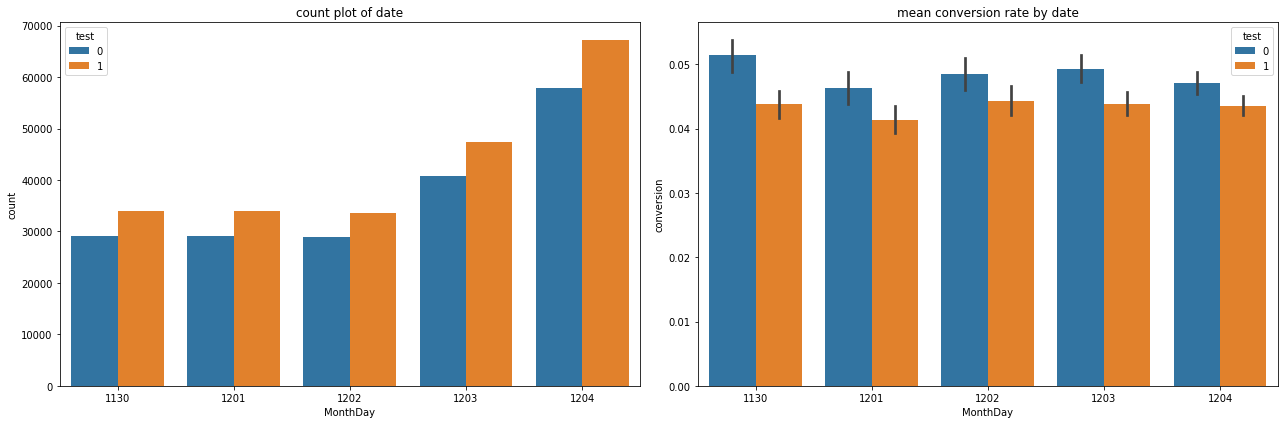

In [39]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize = (18,6))
sns.countplot(x = 'MonthDay', hue = 'test',ax = ax[0], data = test_data)
ax[0].set_title('count plot of date')

sns.barplot(x = 'MonthDay', y = 'conversion', data= test_data, hue = 'test', ax = ax[1])
ax[1].set_title('mean conversion rate by date')
plt.tight_layout()

b. source

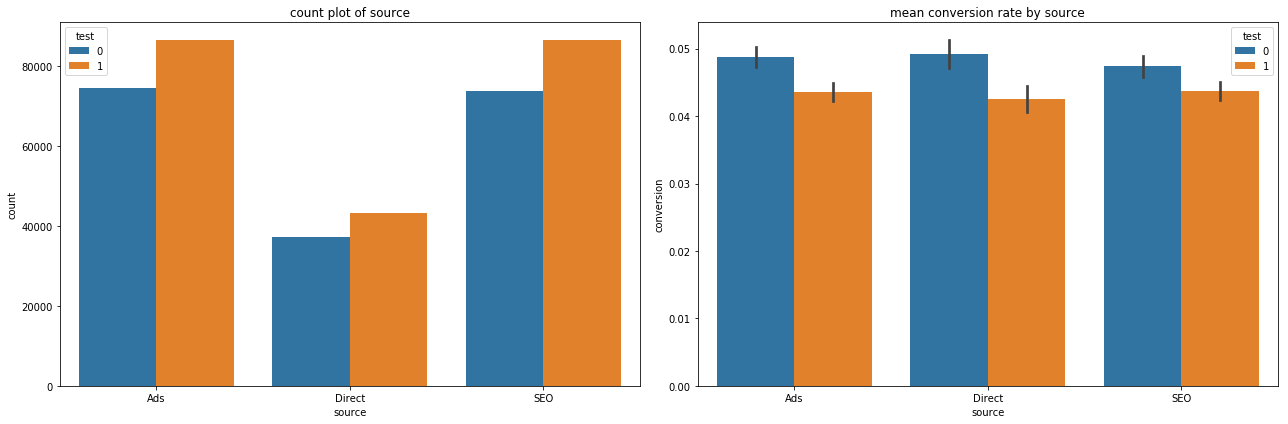

In [41]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize = (18,6))
sns.countplot(x = 'source', hue = 'test',ax = ax[0], data = test_data)
ax[0].set_title('count plot of source')

sns.barplot(x = 'source', y = 'conversion', data= test_data, hue = 'test', ax = ax[1])
ax[1].set_title('mean conversion rate by source')
plt.tight_layout()

c. device

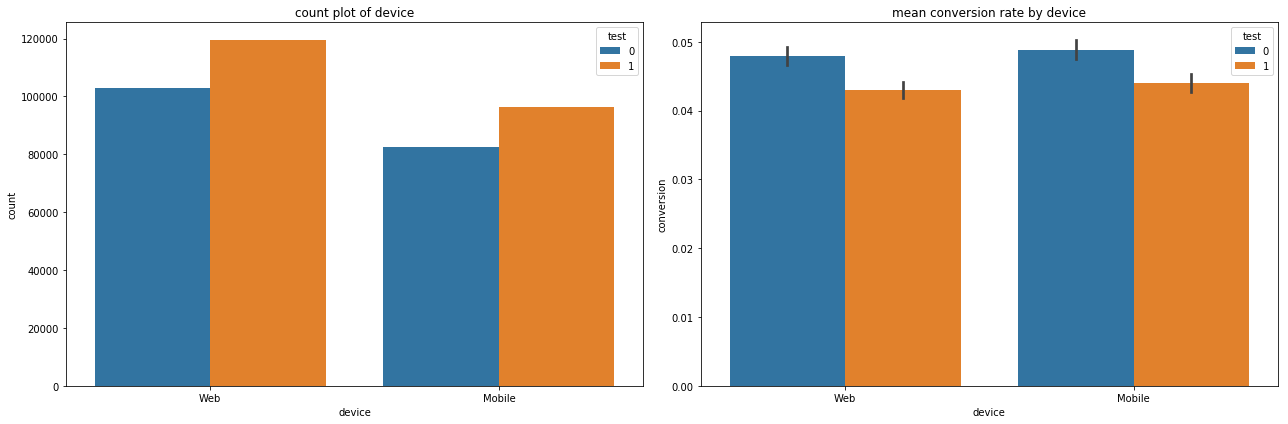

In [42]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize = (18,6))
sns.countplot(x = 'device', hue = 'test',ax = ax[0], data = test_data)
ax[0].set_title('count plot of device')

sns.barplot(x = 'device', y = 'conversion', data= test_data, hue = 'test', ax = ax[1])
ax[1].set_title('mean conversion rate by device')
plt.tight_layout()

d. browser_language

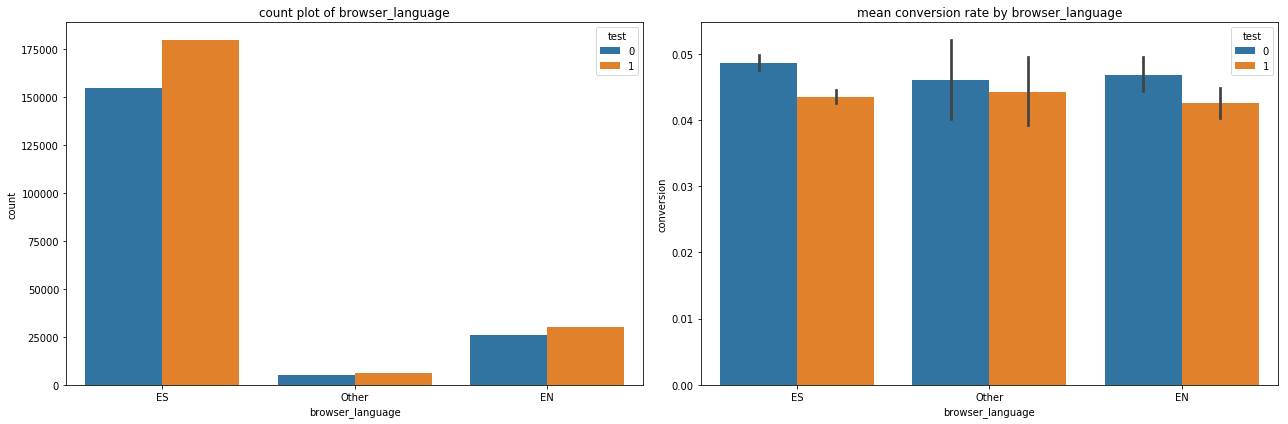

In [43]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize = (18,6))
sns.countplot(x = 'browser_language', hue = 'test',ax = ax[0], data = test_data)
ax[0].set_title('count plot of browser_language')

sns.barplot(x = 'browser_language', y = 'conversion', data= test_data, hue = 'test', ax = ax[1])
ax[1].set_title('mean conversion rate by browser_language')
plt.tight_layout()

e. ads_channel

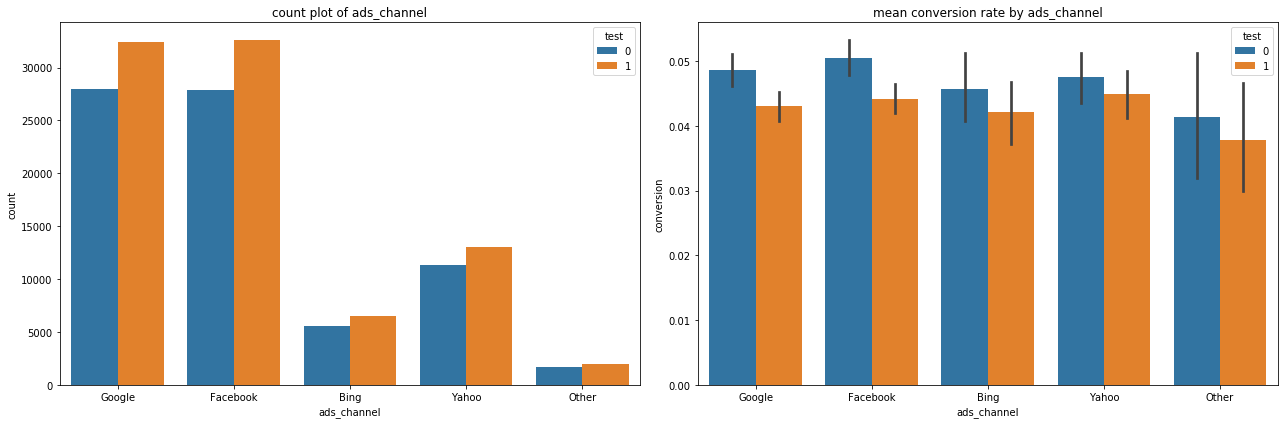

In [44]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize = (18,6))
sns.countplot(x = 'ads_channel', hue = 'test',ax = ax[0], data = test_data)
ax[0].set_title('count plot of ads_channel')

sns.barplot(x = 'ads_channel', y = 'conversion', data= test_data, hue = 'test', ax = ax[1])
ax[1].set_title('mean conversion rate by ads_channel')
plt.tight_layout()

f. browser

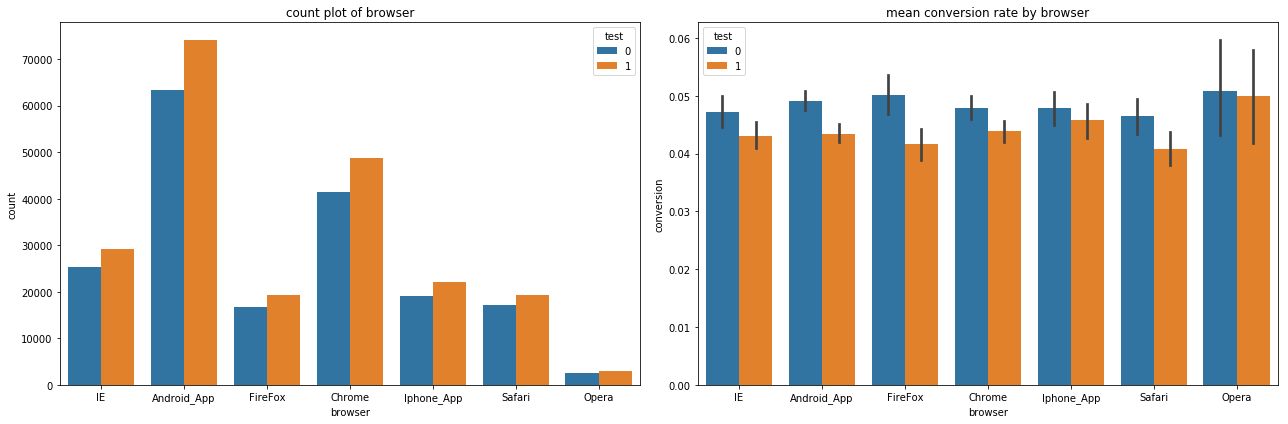

In [45]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize = (18,6))
sns.countplot(x = 'browser', hue = 'test',ax = ax[0], data = test_data)
ax[0].set_title('count plot of browser')

sns.barplot(x = 'browser', y = 'conversion', data= test_data, hue = 'test', ax = ax[1])
ax[1].set_title('mean conversion rate by browser')
plt.tight_layout()

g. sex

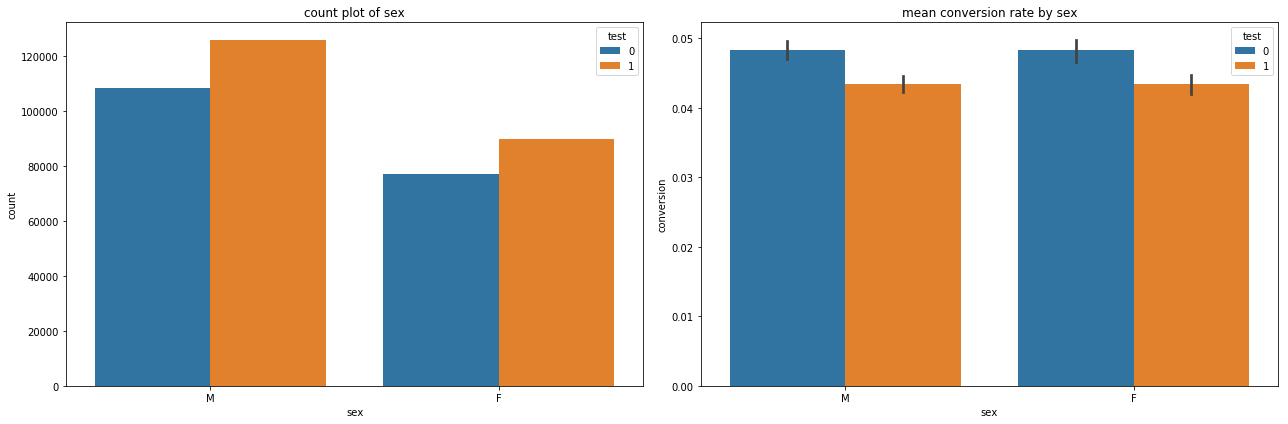

In [46]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize = (18,6))
sns.countplot(x = 'sex', hue = 'test',ax = ax[0], data = test_data)
ax[0].set_title('count plot of sex')

sns.barplot(x = 'sex', y = 'conversion', data= test_data, hue = 'test', ax = ax[1])
ax[1].set_title('mean conversion rate by sex')
plt.tight_layout()

h. age

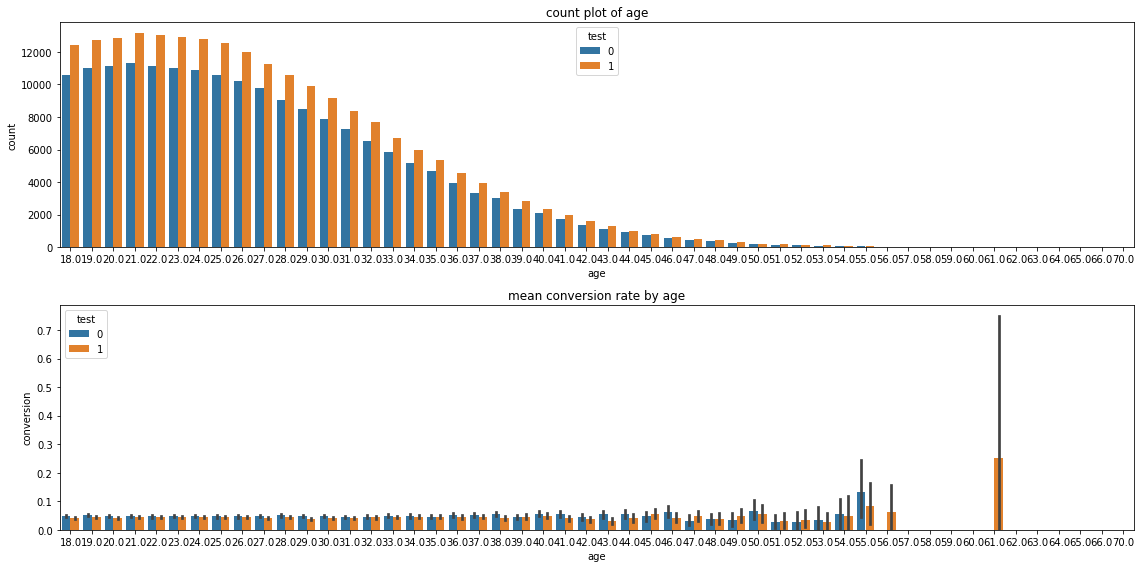

In [48]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize = (16,8))
sns.countplot(x = 'age', hue = 'test',ax = ax[0], data = test_data)
ax[0].set_title('count plot of age')

sns.barplot(x = 'age', y = 'conversion', data= test_data, hue = 'test', ax = ax[1])
ax[1].set_title('mean conversion rate by age')
plt.tight_layout()

In [67]:
## Let's look at country because it makes more sense 
## for each country, calculate the p_value before and after new method applied
countries = [name for name in test_data['country'].unique() if name is not np.nan]

print('{0:15s}{1:>15s}{2:>15s}{3:>10s}'.format('Country','Test Rate','Control Rate','P-Value'))
print('-'* 65)

for country in countries:
    test_val = test_data[(test_data['country'] == country) & (test_data['test'] == 1)]['conversion'].values
    con_val = test_data[(test_data['country'] == country) & (test_data['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    con_mean = con_val.mean()
    p_value = ttest_ind(test_val, con_val, equal_var= False).pvalue
    
    print('{0:15s}{1:15.5f}{2:15.5f}{3:10f}'.format(country,test_mean,con_mean,p_value))    

Country              Test Rate   Control Rate   P-Value
-----------------------------------------------------------------
Mexico                 0.05119        0.04949  0.165544
Venezuela              0.04898        0.05034  0.573702
Bolivia                0.04790        0.04937  0.718885
Colombia               0.05057        0.05209  0.423719
Uruguay                0.01291        0.01205  0.879764
El Salvador            0.04795        0.05355  0.248127
Nicaragua              0.05418        0.05265  0.780400
Peru                   0.05060        0.04991  0.771953
Costa Rica             0.05474        0.05226  0.687876
Chile                  0.05130        0.04811  0.302848
Argentina              0.01373        0.01507  0.335147
Ecuador                0.04899        0.04915  0.961512
Guatemala              0.04865        0.05064  0.572107
Honduras               0.04754        0.05091  0.471463
Paraguay               0.04923        0.04849  0.883697
Panama                 0.04937        

### Findings:
1. All features seems to have 50/50 split for test and control -> no bias
2. It could be some segment of users morelikely to end up in either test or control. Hence, should create a decision tree model
3. NOTE: Decision_tree.fit(X,y), where all X,y has to be float32, cannot take string values
4. After calculating the p-value when holding group by countries, the p-values are not significant, which is not desired, but at least proved that new method didn't make things worse, because test_mean and con_mean are pretty similar

### Notes:
1. we should at least run a test for 1 full week to capture weekly pattern. 2 weeks are much better 